In [50]:
import cv2
import json
import pprint
import numpy as np
import scipy.sparse
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
from shapely import geometry
from descartes import PolygonPatch

%matplotlib inline

In [120]:
def img_shrink(img_url, MAX_DIM=1024, show=0):
    img = skimage.io.imread(img_url)
    (h,w) = img.shape
    img_aspect = max(h,w) / min(h,w)
    MIN_DIM = MAX_DIM / img_aspect
    img_trans = skimage.transform.resize(img, (MIN_DIM, MAX_DIM), preserve_range=True)
    img_trans = np.array(img_trans, dtype=np.uint16)
    if show:
        f,axarr = plt.subplots(1,2, figsize=(15,15))
        axarr[0].imshow(img)
        axarr[1].imshow(img_trans)
    return img_trans

def convert_mapillary_to_cityscapes(mapillary_image_url, mapillary_to_cityscapes_mapping_url, mapillary_binarymap_save_url
                                        , format_img, class_id_study = None
                                        , verbose=0, show = 0):
    ## 1. IMAGE READ
    mapillary_image_name = mapillary_image_url.split('.png')[0].split('/')[2]
    img_int16 = skimage.io.imread(mapillary_image_url)
    # img_int16 = img_shrink(mapillary_image_url)
    img_int8  = cv2.imread(mapillary_image_url)
    (w, h) = img_int16.shape
    class_ids = np.unique(img_int8)
    class_instance_ids = np.unique(img_int16)
    
    ## 2. IMAGE SHOW
    if verbose:
        print ('Shape : ', img_int16.shape)
        print ('Classes : ', class_ids)
        print ('Classes_Instances : ', class_instance_ids)
        pprint.pprint(class_instance_ids_count)
        
    if show:
        f, axarr = plt.subplots(1,2, figsize = (10,10))
        axarr[0].imshow(img_int8, cmap = 'gray')
        axarr[1].imshow(img_int16, cmap = 'gray')
    
    ## 3. MAPPING(MAPI -> CITY) READ
    # scp merge__cityscapes_mapillary_v1.json playment-gpu:/home/play/playment/production/Mask_RCNN/demo/raw
    with open(mapillary_to_cityscapes_mapping_url, 'r') as fp:
        converter_json = json.load(fp)
        if class_id_study != None:
            print ('Class_Study : {0} : {1}'.format(class_id_study, converter_json['mapillary_class'][str(class_id_study)]['cityscapes_label']))
    
    
    ## 4. MAPPING INT8->INT16
    class_instance_ids_count = np.unique(img_int16, return_counts=True)
    tot_pixels = float(w * h)
    class_instance_ids_count = {i:round((j/tot_pixels)*100.0,2) for i,j in zip(class_instance_ids_count[0], class_instance_ids_count[1])}
    
    class_ids_mapping_16_8 = {class_id : [] for class_id in class_ids}
    for class_instance_id in class_instance_ids:
        # Remove instances that are small
        if class_instance_ids_count[class_instance_id] <= 0.1: # mask-size check
            img_int16[img_int16 == instance_id] = 0
        else:
            for class_id in class_ids_mapping_16_8:
                cityscapes_class = converter_json['mapillary_class'][str(class_id)]['cityscapes_class']
                class_floor, class_cieling = class_id*256, (class_id + 1)*256
                if class_instance_id >= class_id*256 and class_instance_id < (class_id + 1)*256:
                    # remove (class, instance) pair that we dont consider training for
                    if int(cityscapes_class) == 0:
                        img_int16[img_int16 == instance_id] = 0
                    else:
                        class_ids_mapping_16_8[class_id].append(class_instance_id)   
    
    class_ids_mapping_16_8_copy = class_ids_mapping_16_8.copy()
    for class_id in class_ids_mapping_16_8_copy:
        if class_ids_mapping_16_8_copy[class_id] == []:
            class_ids_mapping_16_8.pop(class_id)
            
    pprint.pprint(class_ids_mapping_16_8)
             
    
    if format_img == '.npz':
        res = {}
    
    ## 5. EXTRACTING INDIVIDUAL MASKS
    masks_res = []
    class_ids_res = []
    for class_id_int8 in sorted(class_ids_mapping_16_8):
        if len(class_ids_mapping_16_8[class_id_int8]) == 0:
            class_ids_mapping_16_8[class_id_int8] = [class_id_int8 * 256]
        if class_id_study != None and class_id_study != class_id_int8:
            continue
        if class_id_study == class_id_int8:
            class_id_study_instances = len(class_ids_mapping_16_8[class_id_study])
            print (' --> Total instances : ', class_id_study_instances)
            if show:
                f, axarr = plt.subplots(1, class_id_study_instances, figsize=(15,15))
        
        for inst_id, class_id_int16 in enumerate(sorted(class_ids_mapping_16_8[class_id_int8])):
            tmp = np.zeros((img_int16.shape), dtype=np.uint8)
            tmp[img_int16 != int(class_id_int16)] = 0
            tmp[img_int16 == int(class_id_int16)] = 1
            # tmp = np.packbits(tmp, axis=None)
            tmp = scipy.sparse.csc_matrix(tmp)
            # print (tmp2.data.nbytes, tmp2.indptr.nbytes, tmp2.indices.nbytes)            
            
            class_id_cityscapes = converter_json['mapillary_class'][str(class_id_int8)]['cityscapes_class']
            tmp_name = '{0}'.format(inst_id + 1)
            if format_img != '.npz': 
                save_url = '{0}/{1}.png'.format(mapillary_binarymap_save_url, tmp_name)
                cv2.imwrite(save_url,tmp)
                if show and class_id_study != None:
                    axarr[inst_id].imshow(tmp, cmap = 'gray')
            
            else:
                if str(class_id_cityscapes) not in res:
                    res[str(class_id_cityscapes)] = {}                
                res[str(class_id_cityscapes)][tmp_name] = tmp
                
    if format_img == '.npz':
        np.savez('{0}/{1}.npz'.format(mapillary_binarymap_save_url, mapillary_image_name) , **res)
                 
    if show:
        pass
    
    # pprint.pprint(res)
    print ('City Classes to Study : ', len(res))
    return res

if __name__ == "__main__":
    # mapillary_image_url = './data/_1AbvbARvB-5S0rAPN02Mg.png'
    mapillary_image_url = './data/_2g1p_iHAUNc2KTgESz5KA.png'
    mapillary_to_cityscapes_mapping_url = './merge__cityscapes_mapillary_v1.json'
    mapillary_binarymap_save_url = './data'
    
    res = convert_mapillary_to_cityscapes(mapillary_image_url, mapillary_to_cityscapes_mapping_url, mapillary_binarymap_save_url
                                    ,format_img = '.npz', class_id_study=None, show = 0, verbose=0)

/home/play/.local/lib/python3.5/site-packages/ipykernel_launcher.py:63: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/play/.local/lib/python3.5/site-packages/ipykernel_launcher.py:55: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


{2: [512],
 15: [3840],
 27: [6912],
 45: [11552],
 54: [13824],
 55: [14081, 14082, 14083, 14084],
 61: [15616]}
City Classes to Study :  6


# SCRATCHPAD

In [118]:
# Scratch 1 #check city_classes
import json
import numpy as np

with open('./merge__cityscapes_mapillary_v1.json', 'r') as fp:
    converter_json = json.load(fp)
    city_class = []
    for class_id in converter_json['mapillary_class']:
        city_class.append(converter_json['mapillary_class'][class_id]['cityscapes_class'])

    print (np.unique(city_class))

['' '0' '1' '17' '23' '24' '25' '26' '27' '28' '29' '30' '31' '32' '33'
 '8']


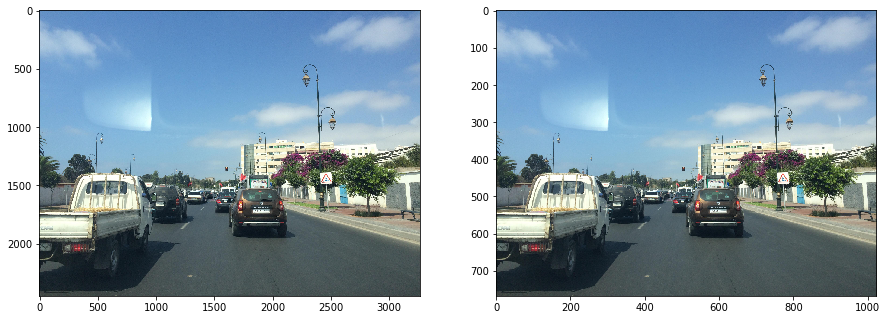

In [122]:
# Scratch 2 (Shrink)
def img_shrink(img_url, MAX_DIM=1024, show=0, verbose=0):
    img = skimage.io.imread(img_url)
    if verbose : print (img.shape, list(np.unique(img)))
    if len(img.shape) == 3: (h,w,d) = img.shape
    elif len(img.shape) == 2: (h,w) = img.shape
        
    img_aspect = max(h,w) / min(h,w)
    MIN_DIM = MAX_DIM / img_aspect
    img_trans = skimage.transform.resize(img, (MIN_DIM, MAX_DIM), preserve_range=True, mode='reflect')
    img_trans = np.array(img_trans, dtype = np.uint16)
    if verbose : print (img_trans.shape, list(np.unique(img_trans)))
    
    if show:
        f,axarr = plt.subplots(1,2, figsize=(15,15))
        axarr[0].imshow(img)
        axarr[1].imshow(img_trans)
    return img_trans

# mapillary_image_url = './data/_1AbvbARvB-5S0rAPN02Mg.jpg'
mapillary_image_url = './data/_2g1p_iHAUNc2KTgESz5KA.jpg'
img_trans = img_shrink(mapillary_image_url, show=1)

Count :  9 9  | Shape: (2448, 3264)
 --> Error: A LinearRing must have at least 3 coordinate tuples


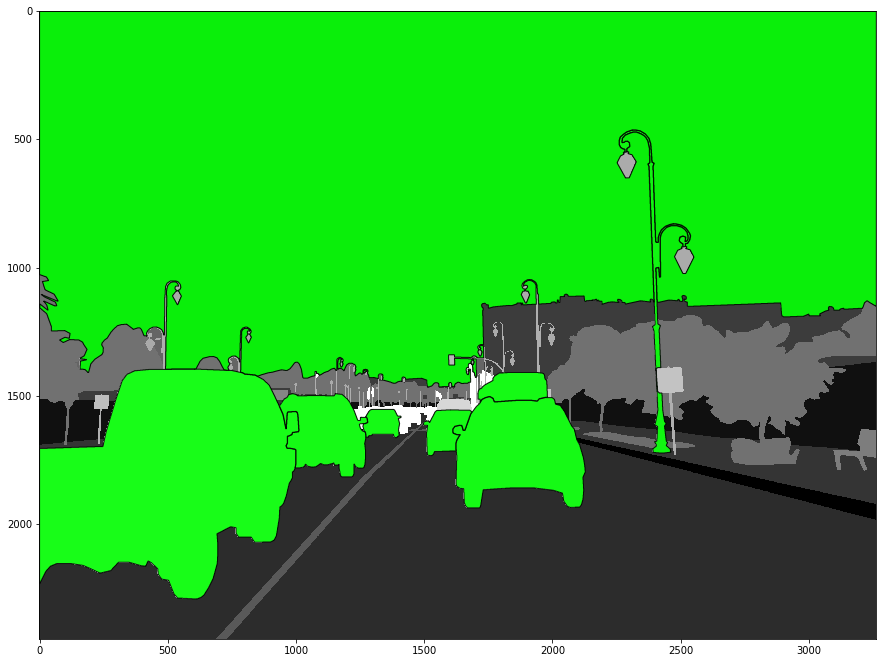

In [123]:
# Scratch 3 (check what classes you are studying)
def check_masks(filename):
    masks_res     = []
    class_ids_res = []
    masks_sparse = np.load('./data/{0}.npz'.format(filename))
    for class_id in masks_sparse:
        for instance_id in masks_sparse[class_id].item():
            mask_class_instance = np.array(masks_sparse[class_id].item()[instance_id].todense())
            masks_res.append(mask_class_instance)
            class_ids_res.append(class_id)

    print ('Count : ', len(class_ids_res), len(masks_res),' | Shape:', masks_res[0].shape)
    h, w = masks_res[0].shape
    
    f, axarr = plt.subplots(1, figsize=(15,15))
    frame1 = plt.gca()
    # frame1.set_xlim(0,w)
    # frame1.set_ylim(0,h)
    axarr.imshow(skimage.io.imread('./data/{0}.png'.format(filename)), cmap='gray')

    for i, mask in enumerate(masks_res):
        tmp = np.array(mask, dtype = np.uint8).copy()
        # print (class_ids_res[i])
        try:
            _, contours, hierarchy = cv2.findContours(tmp, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            hierarchy_idx = {}
            for idx, contour_info in enumerate(hierarchy[0]):
                if contour_info[3] == -1:
                    hierarchy_idx[idx] = {}
                else:
                    hierarchy_idx[contour_info[3]] = {}

            for idx in hierarchy_idx:
                contour_pts = [list(pt[0]) for pt in contours[idx]]
            contour_pts = np.array(contour_pts)
            poly = geometry.Polygon(contour_pts)
            patch = PolygonPatch(poly, facecolor = [0,1,0], edgecolor = [0,0,0], alpha = 0.9)
            axarr.add_patch(patch)
        except Exception as e:
            print (' --> Error:', e)


    plt.savefig('./data/{0}_masks.png'.format(filename), dpi=100)

if __name__ == "__main__":
    # check_masks('_1AbvbARvB-5S0rAPN02Mg')
    check_masks('_2g1p_iHAUNc2KTgESz5KA')

In [133]:
# Scratch4 (mask shrink only)
def img_shrink(img, MAX_DIM=1024, show=0):
    print ('-->', img.shape, list(np.unique(img)))
    (h,w) = img.shape
    img_aspect = max(h,w) / min(h,w)
    MIN_DIM = MAX_DIM / img_aspect
    img_trans = skimage.transform.resize(img, (MIN_DIM, MAX_DIM), preserve_range=True, mode='reflect')
    img_trans = np.array(img_trans, dtype = np.uint16)
    print ('-------->', img_trans.shape, list(np.unique(img_trans)))
    
    if show:
        f,axarr = plt.subplots(1,2, figsize=(15,15))
        axarr[0].imshow(img)
        axarr[1].imshow(img_trans)
    return img_trans

if __name__ == "__main__":
    filename = '_1AbvbARvB-5S0rAPN02Mg'
    filename = '_2g1p_iHAUNc2KTgESz5KA'
    masks_res     = []
    class_ids_res = []
    masks_sparse = np.load('./data/{0}.npz'.format(filename))
    for class_id in masks_sparse:
        for instance_id in masks_sparse[class_id].item():
            mask_class_instance = np.array(masks_sparse[class_id].item()[instance_id].todense())
            masks_res.append(mask_class_instance)
            class_ids_res.append(class_id)

    print ('Count : ', len(class_ids_res), len(masks_res),' | Shape:', masks_res[0].shape)
    h, w = masks_res[0].shape
    
    for mask in masks_res:
        mask_trans = img_shrink(mask, show=0)
        break

Count :  9 9  | Shape: (2448, 3264)
--> (2448, 3264) [0, 1]
--------> (768, 1024) [0, 1]


Count :  9 9  | Shape: (2448, 3264)


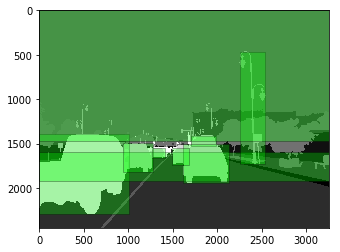

In [139]:
# SCRATCH - CHECK BBOXES
def bboxes(filename, masks_res):
    img_url = './data/{0}.png'.format(filename)
    img = skimage.io.imread(img_url)
    f,axarr = plt.subplots(1)
    axarr.imshow(img, cmap = 'gray')
    
    for i,mask in enumerate(masks_res):
        horizontal_indicies = np.where(np.any(mask, axis=0))[0]
        vertical_indicies = np.where(np.any(mask, axis=1))[0]
        if horizontal_indicies.shape[0]:
            x1, x2 = horizontal_indicies[[0, -1]]
            y1, y2 = vertical_indicies[[0, -1]]
            # x2 and y2 should not be part of the box. Increment by 1.
            x2 += 1
            y2 += 1
        else:
            # No mask for this instance. Might happen due to
            # resizing or cropping. Set bbox to zeros
            x1, x2, y1, y2 = 0, 0, 0, 0
            
        poly = box(x1, y1, x2, y2) #(minx, miny, maxx, maxy)
        patch = PolygonPatch(poly, facecolor = [0,1,0], edgecolor = [0,0,0], alpha = 0.3)
        axarr.add_patch(patch)
        #boxes[i] = np.array([y1, x1, y2, x2])

if __name__ == "__main__":
    filename = '_1AbvbARvB-5S0rAPN02Mg'
    filename = '_2g1p_iHAUNc2KTgESz5KA'
    masks_res     = []
    class_ids_res = []
    masks_sparse = np.load('./data/{0}.npz'.format(filename))
    for class_id in masks_sparse:
        for instance_id in masks_sparse[class_id].item():
            mask_class_instance = np.array(masks_sparse[class_id].item()[instance_id].todense())
            masks_res.append(mask_class_instance)
            class_ids_res.append(class_id)
    
    bboxes(filename, masks_res)
    
    print ('Count : ', len(class_ids_res), len(masks_res),' | Shape:', masks_res[0].shape)
    h, w = masks_res[0].shape

In [3]:
import colorsys

In [6]:
N = 4
brightness = 0.7
hsv = [(i / N, 1, brightness) for i in range(N)]
colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
print (colors)
# random.shuffle(colors)

[(0.7, 0.0, 0.0), (0.35, 0.7, 0.0), (0.0, 0.7, 0.7), (0.35, 0.0, 0.7)]
